Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔹 Visualizando as primeiras linhas do dataset:
   Competência concessão                                        Espécie  \
0                 202305  Amp. Social Pessoa Portadora Deficiencia        
1                 202305  Aposentadoria por Idade                         
2                 202305  Aposentadoria por Idade                         
3                 202305  Amp. Social Pessoa Portadora Deficiencia        
4                 202305  Amp. Social Pessoa Portadora Deficiencia        

                                             CID  \
0  G80.9 Paralisia Cerebral Infantil Ne            
1  Zerados                                         
2  Zerados                                         
3  G91   Hidrocefalia                              
4  F84.0 Autismo Infantil                          

                                   Despacho Dt Nascimento   

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


🔍 Features selecionadas: ['CID', 'Despacho', 'Sexo.', 'Clientela', 'Tipo de Cálculo', 'Mun Resid', 'Vínculo dependentes', 'Forma Filiação', 'UF', 'Qt SM RMI'] 

📊 MÉTRICAS DO MODELO:
Acurácia: 0.91
Precisão: 0.90
Recall: 0.91
F1-Score: 0.90

📄 RELATÓRIO DE CLASSIFICAÇÃO:
                                               precision    recall  f1-score   support

Amp. Social Pessoa Portadora Deficiencia            0.94      0.96      0.95     10142
Amparo Social ao Idoso                              0.96      0.94      0.95      9800
Aposent. Invalidez Acidente Trabalho                0.14      0.06      0.08       176
Aposent. Tempo de Serviço de Professor              0.33      0.27      0.30       176
Aposentadoria Especial                              0.59      0.59      0.59       467
Aposentadoria Invalidez Previdenciária              0.64      0.47      0.55      4601
Aposentadoria por Idade                             0.86      0.88      0.87     22210
Aposentadoria por Tempo de Cont

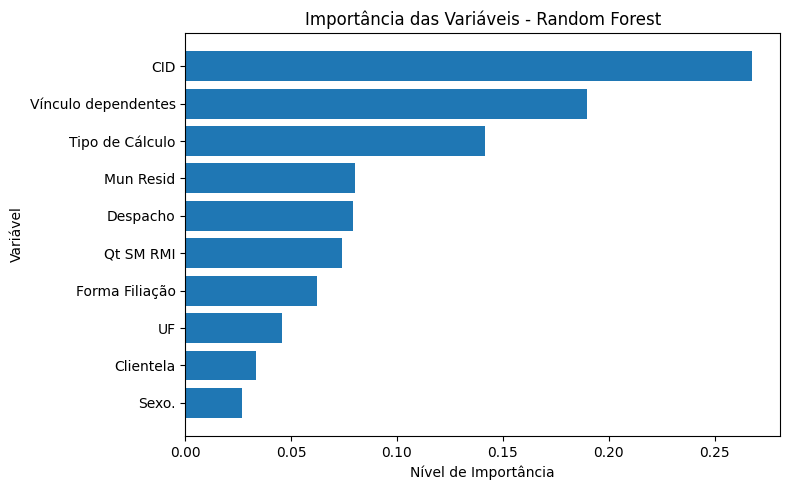

In [7]:
# ==============================
# PROJETO - MODELAGEM INSS (CORRIGIDO COMPLETO)
# ==============================

import pandas as pd
import warnings
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning

# Ignorar avisos de métricas indefinidas
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 1️⃣ Montar o Google Drive
drive.mount('/content/drive')

# 2️⃣ Caminho da pasta e arquivo CSV
folder_path = "/content/drive/MyDrive/Colab Notebooks"
csv_file = "D.SDA.PDA.001.CON.202305.csv"
csv_path = f"{folder_path}/{csv_file}"

# 3️⃣ Carregar CSV
df = pd.read_csv(csv_path, sep=";", low_memory=False, encoding="latin1")
print("🔹 Visualizando as primeiras linhas do dataset:")
print(df.head(), "\n")

# 4️⃣ Definir variável alvo
target = 'Espécie'

# Remover linhas sem alvo
df = df.dropna(subset=[target])

# 5️⃣ Preparar features
features = [c for c in df.columns if c != target]

# Converter colunas categóricas em números
for col in df[features]:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df[features]
y = LabelEncoder().fit_transform(df[target])

# ==============================
# i) SELEÇÃO DE FEATURES
# ==============================
k = min(10, X.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Nomes das colunas selecionadas
selected_features = [features[i] for i in range(len(features)) if selector.get_support()[i]]
print("🔍 Features selecionadas:", selected_features, "\n")

# ==============================
# ii) TREINAMENTO DO MODELO
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ==============================
# iii) MÉTRICAS DE VALIDAÇÃO
# ==============================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("📊 MÉTRICAS DO MODELO:")
print(f"Acurácia: {acc:.2f}")
print(f"Precisão: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}\n")

# Relatório de classificação com correção de labels ausentes
labels = unique_labels(y_test, y_pred)
print("📄 RELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred, labels=labels, target_names=LabelEncoder().fit(df[target]).inverse_transform(labels)))

# ==============================
# iv) CONCLUSÕES
# ==============================
print("\n📌 CONCLUSÕES:")
if acc > 0.8:
    print("✅ O modelo apresentou excelente desempenho, com acurácia acima de 80%, indicando boa capacidade preditiva.")
elif acc > 0.6:
    print("⚙️ O modelo apresentou desempenho satisfatório, podendo ser aprimorado com mais features ou ajustes nos hiperparâmetros.")
else:
    print("⚠️ O desempenho do modelo foi limitado; é recomendável revisar as variáveis utilizadas e realizar mais tratamento dos dados.")

print("As variáveis selecionadas mostraram-se relevantes para distinguir os tipos de benefícios concedidos.")
print("Modelos de árvore como o Random Forest são úteis nesse contexto, pois interpretam relações não lineares e interações entre variáveis.\n")

# ==============================
# v) IMPORTÂNCIA DAS VARIÁVEIS
# ==============================
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importância': importances
}).sort_values(by='Importância', ascending=False)

print("🌲 Importância das variáveis:")
print(feature_importance, "\n")

# Gráfico de importância
plt.figure(figsize=(8,5))
plt.barh(feature_importance['Feature'], feature_importance['Importância'])
plt.gca().invert_yaxis()
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Nível de Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()
